## MDEO model: DM scan without kinetic mixing $\epsilon$

The idea is to do a firts DM random scan

In [1]:
import numpy as np
import pandas as pd
import subprocess
import time
import sys

%matplotlib inline
import matplotlib.pyplot as plt 

In [2]:
import pyslha
import pyMDEO_LesHouches_generator

import neutrino_analytic
import NEUTRINO2018

In [3]:
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

#For good plots
plt.rcParams.update({'font.size': 12}) 
#plt.rc('font',size='18')

## Dark matter $\Omega h^2$

In [4]:
#Experimental values for DM:Planck results 2018
e = 5
Omega = 0.1200
Omega_min=Omega - e*0.0012
Omega_max=Omega + e*0.0012
print( Omega_min, Omega,Omega_max)

0.11399999999999999 0.12 0.126


In [5]:
from scipy import interpolate
from scipy.signal import savgol_filter

#fitOmega=interpolate.interp1d(xd.MZp, xd.Omega1)

In [6]:
import numpy as np
import pandas as pd
from scipy.special import zeta
from scipy.optimize import bisect
from scipy import integrate as intg
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
USETEX=False
if USETEX:
    matplotlib.rcParams['text.usetex'] = True
    #matplotlib.rcParams['text.latex.unicode'] = True

In [7]:
Tdec_νL = 0.0023
T, g = np.loadtxt('GT.dat',usecols=(0,1),unpack=True); T*=1e-3
geff = InterpolatedUnivariateSpline(T, g)
g_eff = lambda T: geff(T)

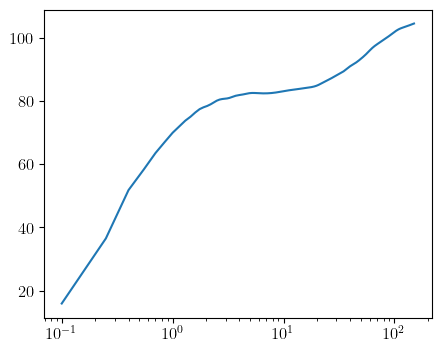

In [8]:
plt.figure(figsize=(5,4))

n=np.linspace(1e-1,1.5e2,1000)

plt.semilogx(n,g_eff(n))

In [9]:
gd = pd.read_csv('gT.csv')

In [10]:
#NEW
def relic_abundance(a, b, xf, m):
    MPl=1.22E19
    xd2=gd[gd['T']>m/xf].copy()
    T=np.asarray(xd2['T'])
    g=np.asarray(xd2['g'])
    geff=g*T
    thavgeff=geff.sum()/T.sum()    
    sqrtg=np.sqrt(thavgeff)
    
    return 2*1.04E9*xf/(MPl*sqrtg*(a + 3.0*b/xf))

RELIC DENSITY:

\begin{equation}
\label{eq:RelicAbundance}
\Omega_{\chi} h^{2} \approx \frac{2.08 \times 10^{9}\, x_{f}\,\,\text{GeV}^{-1}}{M_{\mathrm{Pl}} \sqrt{g_{*}(T_f)}\left(a+3 b / x_{f}\right)}\,,
\end{equation}

FeynCalc:

\begin{equation}
\langle\sigma{v}\rangle\approx a+bv^2
\end{equation}

FeynCalcl lat version:

\begin{equation}
a=\frac{\text{gBL}^4 \left(1-r^2\right)^{3/2} \left(1519 r^2+162\right)}{16 \pi  \text{Mx}^2 r^2 \left(r^2-2\right)^2}
\end{equation}


\begin{equation}
b=\frac{\text{gBL}^4 \left(-\frac{21261 \text{Ms}^4}{4}-9318 \text{Ms}^2 \text{Mx}^2+\frac{13122 \text{Ms}^4-209952 \text{Ms}^2 \text{Mx}^2+944784 \text{Mx}^4}{r^4}+r^2 \left(6724 \text{Ms}^4-60434 \text{Ms}^2 \text{Mx}^2+35737
   \text{Mx}^4\right)+\frac{-162 \text{Ms}^4+106272 \text{Ms}^2 \text{Mx}^2-894888 \text{Mx}^4}{r^2}+476610 \text{Mx}^4\right)}{384 \pi  \left(\text{Ms}^2 \text{Mx}-4 \text{Mx}^3\right)^2}   
 \end{equation}   

with $r=\frac{m_{Z'}}{M_1}$.

https://inspirehep.net/files/3fb25aaba1b2df77e1e8718195cc1f20
\begin{equation}
\langle\sigma{v}\rangle
\approx\frac{\,g^4_D (1-r^2)^{3/2}(1-r^2/2)^{-2}}{16\pi M_1^2}
\end{equation}



In [11]:
#Seclude WIMP DM work: ONly Vector interation
#https://arxiv.org/pdf/0711.4866.pdf
def a_coefficient_Sec(g1p, r, M1): 
    alpha= g1p**2/(4.*np.pi)
    k = np.pi*(alpha)**2/(M1)**2*np.sqrt(1. - r**2)   
    return k

#https://inspirehep.net/files/3fb25aaba1b2df77e1e8718195cc1f20
#https://arxiv.org/pdf/2203.12034.pdf
#Ernest Ma: vector interation
def a_coefficient_Ma(g1p, r, Mx): 
    k = g1p**4/(16*np.pi*Mx**2)*(1. - r**2)**(1.5)*(1. - r**2/2.)**(-2)     
    return k

#XX to nunu
def a_coefficient_vv(g1p, r, Mx): 
    n = 81.*g1p**4
    d = 16.*np.pi*Mx**2*(r**2-4.)**2
    k = n/d
    return k

#XX to nunu
def b_coefficient_vv(g1p, r, Mx): 
    n = 27.*g1p**4*(41.*r**2-158.)
    d = 16.*np.pi*Mx**2*(r**2-4.)**3
    k = n/d
    return k

#FeynCalc: 4 version with 3/2
def a_coefficient_Fey(g1p, r, Mx): 
    k = g1p**4*(1.-r**2)**(3/2)*(1519*r**2+162)/(16.*np.pi*Mx**2*r**2*(r**2-2.)**2)  
    return k

#FeynCalc: 4 version
def b_coefficient_Fey(g1p, r, Mx,Ms): 
    
    c0 = -21261*Ms**4/4 -9318*Ms**2*Mx**2 +476610*Mx**4
    cm4 = (13122*Ms**4-209952*Ms**2*Mx**2+944784*Mx**4)/r**4 
    cm2 = (-162*Ms**4+106272*Ms**2*Mx**2-894888*Mx**4)/r**2
    c2 = (6724*Ms**4-60434*Ms**2*Mx**2+35737*Mx**4)*r**2
    
    n = g1p**4*(cm4+cm2+c0+c2 )
    
    d = 384.*np.pi*(Ms**2*Mx-4.*Mx**3)**2
    k = n/d 
    return k

#Nicole F.: 1610.03063
def a_coefficient_ZZ(g1p, MZp, Mx, QA, QV): 
    
    nZ = (MZp/Mx)**2
    n = g1p**4*(1.-nZ)**(3/2)*(2.*QA**2*QV**2*(4.-3.*nZ)+QA**4*nZ+QV**4*nZ)
    d = 4.*np.pi*Mx**2*(nZ-2.)**2*nZ
    k = n/d
    return k

def a_coefficient_sZ(g1p, MZp, Mx, Ms, QA, QV, yx): 
    
    ns = (Ms/Mx)**2
    nZ = (MZp/Mx)**2
    QS = 1/2

    k1 = g1p**2*np.sqrt((ns-nZ-4.)**2-16.*nZ)/(256.*np.pi*Mx**2*(nZ-4.)**2*nZ**2*(ns+nZ-4.)**2)

    k2 = g1p**2*QS**2*(ns+nZ-4)**2*(QA**1*(nZ-4)**2*((ns-nZ-4)**2-16*nZ)+QV**2*nZ**2*((ns-nZ-4)**2+32*nZ))

    k3 = 24*np.sqrt(2.)*g1p*QS*QV**2*yx*(nZ-4.)*nZ**(5/2)*(ns**2-8*ns-nZ**2+16)+4*QV**2*yx**2*(nZ-4)**2*nZ**2*((ns-nZ-4)**2+8*nZ)

    k =k1*(k2+k3)

    return k

In [12]:
print(a_coefficient_ZZ(0.1, 0.5, 100,1/2,1/2),a_coefficient_vv(0.1, 0.5, 100),b_coefficient_vv(0.1, 0.5, 100))
print('a_coefficient_ZZ=',a_coefficient_ZZ(0.01,50,86.1,1/2,9/2))
print('a_coefficient_sZ=',a_coefficient_sZ(0.01,50,86.1,50.,1/2,9/2,0.5))

3.978774105147102e-06 1.1459155902616466e-09 1.5049691418769628e-08
a_coefficient_ZZ= 1.0471177882768053e-11
a_coefficient_sZ= 1.8522127744378036e-09


In [13]:
print('a =',a_coefficient_Fey(0.1,0.5,10),'b =',b_coefficient_Fey(0.1,0.5,10,200.01))
print('a =',a_coefficient_Fey(0.1,0.5,100),'b =',b_coefficient_Fey(0.1,0.5,100,200.01))

a = 9.143339666166e-06 b = 0.00016775600142894927
a = 9.143339666165999e-08 b = 180.2031360850741


In [14]:
#http://www.saha.ac.in/theory/palashbaran.pal/conv.html
GeVtocmmin1 = 5.06*1e+13
GeVtosegmin1 = 1.52*1e+24
tocm3sm1 = GeVtosegmin1/(GeVtocmmin1)**3

print(GeVtocmmin1,GeVtosegmin1, GeVtosegmin1/(GeVtocmmin1)**3)

50599999999999.99 1.52e+24 1.1732539834905879e-17


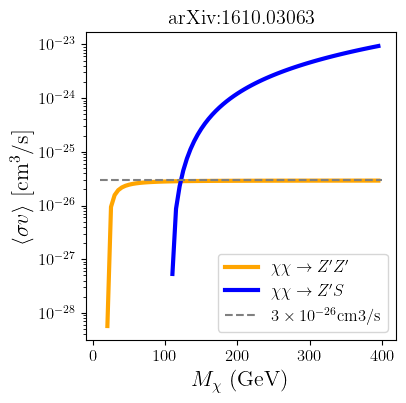

In [15]:
plt.figure(figsize=(4,4))

DM = np.arange(20.1,400,5)
DM2 = np.arange(110.1,400,5)

plt.semilogy(DM, a_coefficient_ZZ(g1p=0.1, MZp=20., Mx=DM, QA=1/2, QV=1/2)*tocm3sm1,\
             color='orange', lw=3,label=r'$\chi\chi\to Z^{\prime}Z^{\prime}$')

plt.semilogy(DM2, a_coefficient_sZ(g1p=0.1, MZp=20, Mx=DM2, Ms=200, QA=1/2, QV=1/2, yx=0.5)*tocm3sm1,\
             color='blue', lw=3,label=r'$\chi\chi\to Z^{\prime}S$')

plt.hlines(3*1.e-26,10,400,color='grey',linestyle='--',label=r'$3\times 10^{-26}$cm3/s')


plt.xlabel(r'$M_{\chi}$ (GeV)',size=16)
plt.ylabel(r'$\langle\sigma v\rangle$ [cm$^3/$s]',size=16)
plt.legend(loc='lower right')
plt.title('arXiv:1610.03063')
#plt.grid()

#plt.ylim(1e-29,1e-22)
#plt.xlim(0, 400)

plt.show()

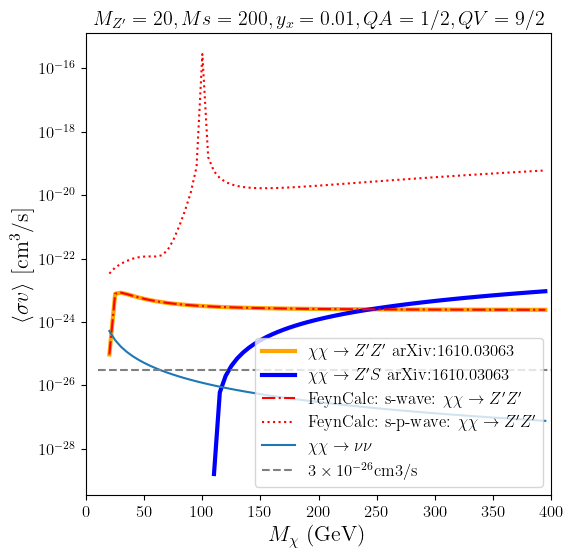

In [16]:
plt.figure(figsize=(6,6))

DM = np.arange(20.1,400,5)
DM2 = np.arange(110.1,400,5)

plt.semilogy(DM, a_coefficient_ZZ(g1p=0.1, MZp=20., Mx=DM, QA=1/2, QV=9/2)*tocm3sm1,\
             color='orange', lw=3,label=r'$\chi\chi\to Z^{\prime}Z^{\prime}$ arXiv:1610.03063')

plt.semilogy(DM2, a_coefficient_sZ(g1p=0.1, MZp=20, Mx=DM2, Ms=200, QA=1/2, QV=9/2, yx=0.01)*tocm3sm1,\
             color='blue', lw=3,label=r'$\chi\chi\to Z^{\prime}S$ arXiv:1610.03063')

plt.semilogy(DM,(a_coefficient_Fey(g1p=0.1, r=(20./DM), Mx=DM)+0*b_coefficient_Fey(g1p=0.1,\
                r=(20./DM), Mx=DM, Ms=200))*tocm3sm1,'r-.',\
             label=r'FeynCalc: s-wave: $\chi\chi \to Z^{\prime}Z^{\prime}$')

plt.semilogy(DM,(a_coefficient_Fey(g1p=0.1, r=(20./DM), Mx=DM)+1*b_coefficient_Fey(g1p=0.1,\
                r=(20./DM), Mx=DM, Ms=200))*tocm3sm1,'r:',\
             label=r'FeynCalc: s-p-wave: $\chi\chi \to Z^{\prime}Z^{\prime}$')

plt.semilogy(DM, a_coefficient_vv(g1p=0.1, r=(20./DM), Mx=DM)*tocm3sm1,\
             label=r'$\chi\chi \to \nu\nu$')

plt.hlines(3*1.e-26,10,400,color='grey',linestyle='--',label=r'$3\times 10^{-26}$cm3/s')

plt.xlabel(r'$M_{\chi}$ (GeV)',size=16)
plt.ylabel(r'$\langle\sigma v\rangle$ [cm$^3/$s]',size=16)
plt.legend(loc='lower right')
plt.title(r'$M_{Z^{\prime}}=20, Ms=200, y_x=0.01, QA=1/2, QV=9/2$')
#plt.grid()

#plt.ylim(1e-29,1e-22)
plt.xlim(0, 400)

plt.show()

### Benchmark Points

In [15]:
#Return a Panda: DataFrame
def BPs(Ms,Vx,yx,M2,M3,xf=25):

    MZp = np.arange(10.,100.1)

    y=[]

    for i in MZp:

        g1p = i/(9.*Vx)
        Mx = yx*Vx/np.sqrt(2.)
        
        a = a_coefficient_Fey(g1p,i/Mx,Mx)
        b = b_coefficient_Fey(g1p,i/Mx,Mx,Ms)
        RD = relic_abundance(a, 1.*b, xf, Mx)
        
        mh1 = 125.
        mh2 = Ms
        theta = 1.0E-4
        gamma = 1.0/np.sqrt(1.0+np.tan(2.0*theta)**2.0)
        Lam5 = (0.5/Vx**2.0)*(mh1**2.0+mh2**2.0+gamma*(mh2**2.0-mh1**2.0)) 

        y.append([i,g1p,Mx,Ms,Vx,yx,M2,M3,a,b,RD,Lam5])

    y=np.asarray(y)   

    yd=pd.DataFrame(y,columns=['MZp','g1p','Mx','Ms','Vx','yx','M2','M3','a','b','RD','Lam5'])    
    
    return yd

In [30]:
#********** the Benchamark points ********************
#BP1 = BPs(Ms=1000.,Vx=200.,yx=0.85,M2=700.,M3=750.)
#BP2 = BPs(Ms=500.,Vx=200.,yx=0.85,M2=700.,M3=750.)
BP1 = BPs(Ms=550.,Vx=400.,yx=0.85,M2=1000.,M3=2000.) #L5=1.91
BP2 = BPs(Ms=300.,Vx=200.,yx=0.85,M2=1000.,M3=2000.) #L5=2.25
BP3 = BPs(Ms=552.,Vx=400.,yx=0.85,M2=1000.,M3=2000.) #L5=1.90
BP4 = BPs(Ms=553.,Vx=400.,yx=0.85,M2=1000.,M3=2000.) #L5=1.89
BP5 = BPs(Ms=558.,Vx=400.,yx=0.85,M2=1000.,M3=2000.) #L5=1.94

In [31]:
BP1[:3]

,MZp,g1p,Mx,Ms,Vx,yx,M2,M3,a,b,RD,Lam5
0,10.0,0.002778,240.416306,550.0,400.0,0.85,1000.0,2000.0,4.870657e-13,3.839373e-08,0.096184,1.890625
1,11.0,0.003056,240.416306,550.0,400.0,0.85,1000.0,2000.0,5.912174e-13,3.837044e-08,0.096240,1.890625
2,12.0,0.003333,240.416306,550.0,400.0,0.85,1000.0,2000.0,7.060311e-13,3.834494e-08,0.096302,1.890625


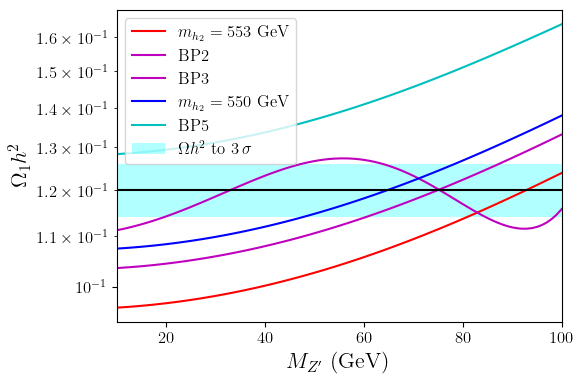

In [32]:
plt.figure(figsize=(6,4))

plt.semilogy( BP1.MZp, BP1.RD, 'r-',label=r'$m_{h_2}=553$ GeV')
plt.semilogy( BP2.MZp, BP2.RD, 'm-',label='BP2 ' )
plt.semilogy( BP3.MZp, BP3.RD, 'm-',label='BP3 ' )
plt.semilogy( BP4.MZp, BP4.RD, 'b-',label=r'$m_{h_2}=550$ GeV' )
plt.semilogy( BP5.MZp, BP5.RD, 'c-',label='BP5 ' )

nn=np.linspace(1e1,1.0e2,10)
plt.fill_between(nn,Omega_min,Omega_max,facecolor='cyan',alpha=0.3,label=r'$\Omega h^2$ to $3\,\sigma$')

plt.hlines(Omega,0.1,1e2, 'k',label='')

plt.xlabel(r'$M_{Z^{\prime}}$ (GeV)',size=16)
plt.ylabel(r'$\Omega_1 h^2$',size=16)
plt.legend()

#plt.ylim(0.023,0.14)
plt.xlim(10, 100)
plt.tight_layout()

#plt.show()

In [33]:
### Read The Output with 2DM candidates
xd = pd.read_csv('xd_scan-noKM-XXZpZp.csv')
del[xd['Unnamed: 0']]

In [34]:
xd['r'] = xd['MZp']/xd['mChi']

In [35]:
x= []

#for i in range(0,2):
for i in range(0,len(xd)):
    
    Ms= xd.mh2[0]
    Yx=xd.Yc[0]
    xf=25 #WARNING
    
    RD_Sec = relic_abundance(a_coefficient_Sec(xd.g1p[i],xd.r[i],xd.mChi[i]), 0, xf, xd.mChi[i])
    RD_Ma  = relic_abundance(a_coefficient_Ma(xd.g1p[i],xd.r[i],xd.mChi[i]), 0, xf, xd.mChi[i])
    RD_Fey = relic_abundance(a_coefficient_Fey(xd.g1p[i],xd.r[i],xd.mChi[i]), 1.*b_coefficient_Fey(xd.g1p[i],xd.r[i],xd.mChi[i],Ms), xf, xd.mChi[i])
    RD_vv  = relic_abundance(a_coefficient_vv(xd.g1p[i],xd.r[i],xd.mChi[i]), b_coefficient_vv(xd.g1p[i],xd.r[i],xd.mChi[i]), xf, xd.mChi[i])
    RD_ZZ  = relic_abundance(a_coefficient_ZZ(xd.g1p[i],xd.MZp[i],xd.mChi[i],1/2,9/2), 0., xf, xd.mChi[i])
    RD_sZ  = relic_abundance(a_coefficient_sZ(xd.g1p[i],xd.MZp[i],xd.mChi[i],Ms,1/2,9/2,Yx), 0., xf, xd.mChi[i])
    
    a_Fey = a_coefficient_Fey(xd.g1p[i],xd.r[i],xd.mChi[i])
    b_Fey = b_coefficient_Fey(xd.g1p[i],xd.r[i],xd.mChi[i],Ms)
    a_vv = a_coefficient_vv(xd.g1p[i],xd.r[i],xd.mChi[i])
    b_vv = a_coefficient_vv(xd.g1p[i],xd.r[i],xd.mChi[i])
    a_sZ = a_coefficient_sZ(xd.g1p[i],xd.MZp[i],xd.mChi[i],Ms,1/2,9/2,Yx)
       
    x.append([RD_Sec, RD_Ma, RD_Fey, RD_vv, RD_ZZ,RD_sZ, a_Fey, b_Fey, a_vv, b_vv,a_sZ])
    
x=np.asarray(x)    

rd=pd.DataFrame(x,columns=['RD_Sec','RD_Ma','RD_Fey','RD_vv','RD_ZZ','RD_sZ','a_Fey','b_Fey','a_vv','b_vv','a_sZ'])

/tmp/ipykernel_7752/4262378841.py:63: RuntimeWarning: invalid value encountered in sqrt
  k1 = g1p**2*np.sqrt((ns-nZ-4.)**2-16.*nZ)/(256.*np.pi*Mx**2*(nZ-4.)**2*nZ**2*(ns+nZ-4.)**2)


In [36]:
rd[:3]

,RD_Sec,RD_Ma,RD_Fey,RD_vv,RD_ZZ,RD_sZ,a_Fey,b_Fey,a_vv,b_vv,a_sZ
0,4.554613e+06,4.554629e+06,0.107824,347404.545427,409.876648,16.391238,1.081280e-12,3.424376e-08,4.944763e-16,4.944763e-16,2.703830e-11
1,7.478047e+05,7.478211e+05,0.108785,56723.755920,158.354353,6.815083,2.798731e-12,3.392672e-08,3.028517e-15,3.028517e-15,6.503094e-11
2,2.755843e+05,2.756009e+05,0.109839,20777.544523,91.500945,4.259032,4.843570e-12,3.358402e-08,8.268300e-15,8.268300e-15,1.040591e-10


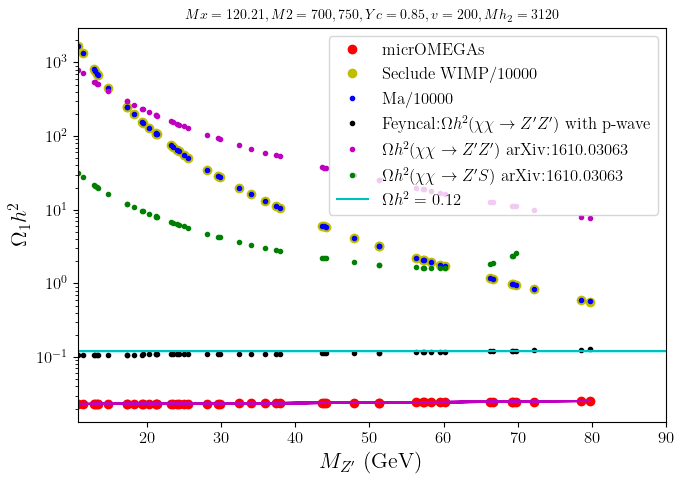

In [37]:
plt.figure(figsize=(7,5))

plt.semilogy(xd.MZp, (xd.Omega1+xd.Omega2),'ro',label='micrOMEGAs')
plt.semilogy(xd.MZp, (xd.Omega1+xd.Omega2),'m-')
plt.plot(xd.MZp, rd.RD_Sec/10000,'yo',label='Seclude WIMP/10000')
plt.plot(xd.MZp, rd.RD_Ma/10000,'b.',label='Ma/10000')
plt.plot(xd.MZp, rd.RD_Fey/1,'k.',label=r'Feyncal:$\Omega h^2(\chi\chi\to Z^{\prime}Z^{\prime})$ with p-wave')

plt.plot(xd.MZp, rd.RD_ZZ,'m.',label=r'$\Omega h^2(\chi\chi\to Z^{\prime}Z^{\prime})$ arXiv:1610.03063')

plt.plot(xd.MZp, rd.RD_sZ,'g.',label=r'$\Omega h^2(\chi\chi\to Z^{\prime}S)$ arXiv:1610.03063')

#plt.plot(xd.MZp, rd.RD_vv,'k.',label=r'$\Omega h^2(\chi\chi\to \nu\nu)$')

n=np.linspace(1e1,1.0e2,10)
plt.fill_between(n,Omega_min,Omega_max,facecolor='cyan',alpha=0.3,label='')

plt.hlines(Omega,0.1,1e2, 'c',label=r'$\Omega h^2=$ 0.12')

plt.xlabel(r'$M_{Z^{\prime}}$ (GeV)',size=16)
plt.ylabel(r'$\Omega_1 h^2$',size=16)
plt.title('$Mx=120.21, M2=700,750, Yc=0.85, v=200, Mh_2=3120$',size=10)
plt.legend()
#plt.grid()

#plt.ylim(0.11,0.2)
plt.xlim(xd.MZp.min(), 90)
plt.tight_layout()

#plt.savefig('plots/benchmark4.pdf')
plt.show()

In [38]:
### Read The micrOMEGAs Output with 1DM candidates
yd = pd.read_csv('Omega3-1DM-BP1.csv')
del[yd['Unnamed: 0']]

yd['r'] = yd['MZp']/yd['mChi']

In [39]:
y= []

#for i in range(0,2):
for i in range(0,len(yd)):
    
    Ms= yd.mh2[0]
    Yx=yd.Yc[0]
    xf= yd['Xf'][i] #WARNING
    

    RD_Fey = relic_abundance(a_coefficient_Fey(yd.g1p[i],yd.r[i],yd.mChi[i]), 1.*b_coefficient_Fey(yd.g1p[i],yd.r[i],yd.mChi[i],Ms), xf, yd.mChi[i])

    a_Fey = a_coefficient_Fey(yd.g1p[i],yd.r[i],yd.mChi[i])
    b_Fey = b_coefficient_Fey(yd.g1p[i],yd.r[i],yd.mChi[i],Ms)
       
    y.append([RD_Fey, a_Fey, b_Fey])
    
y=np.asarray(y)    

rd1DM=pd.DataFrame(y,columns=['RD_Fey','a_Fey','b_Fey'])

In [40]:
rd1DM[:3]

,RD_Fey,a_Fey,b_Fey
0,0.096786,1.081280e-12,3.424376e-08
1,0.114068,2.798731e-12,3.392672e-08
2,0.117884,4.843570e-12,3.358402e-08


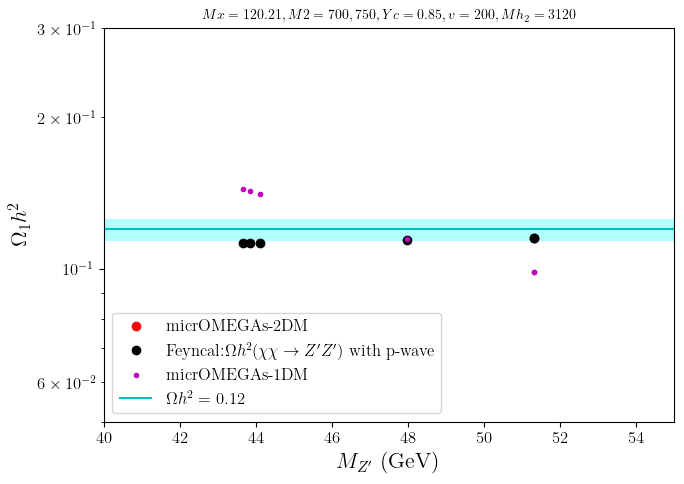

In [41]:
plt.figure(figsize=(7,5))

plt.semilogy(xd.MZp, (xd.Omega1+xd.Omega2),'ro',label='micrOMEGAs-2DM')
#plt.semilogy(xd.MZp, (xd.Omega1+xd.Omega2),'m-')

plt.plot(xd.MZp, rd.RD_Fey/1,'ko',label=r'Feyncal:$\Omega h^2(\chi\chi\to Z^{\prime}Z^{\prime})$ with p-wave')

#plt.plot(xd.MZp, rd1DM.RD_Fey/1,'c.',label='')

plt.plot(xd.MZp, yd.Omega3,'m.',label='micrOMEGAs-1DM')

n=np.linspace(1e1,1.0e2,10)
plt.fill_between(n,Omega_min,Omega_max,facecolor='cyan',alpha=0.3,label='')

plt.hlines(Omega,0.1,1e2, 'c',label=r'$\Omega h^2=$ 0.12')

plt.xlabel(r'$M_{Z^{\prime}}$ (GeV)',size=16)
plt.ylabel(r'$\Omega_1 h^2$',size=16)
plt.title('$Mx=120.21, M2=700,750, Yc=0.85, v=200, Mh_2=3120$',size=10)
plt.legend()
#plt.grid()

plt.ylim(0.05,0.3)
plt.xlim(40, 55)
plt.tight_layout()

#plt.savefig('plots/benchmark4.pdf')
plt.show()

In [42]:
kk = yd[np.logical_and(yd.MZp > 45,yd.MZp < 50) ]

### FINAL PLOT

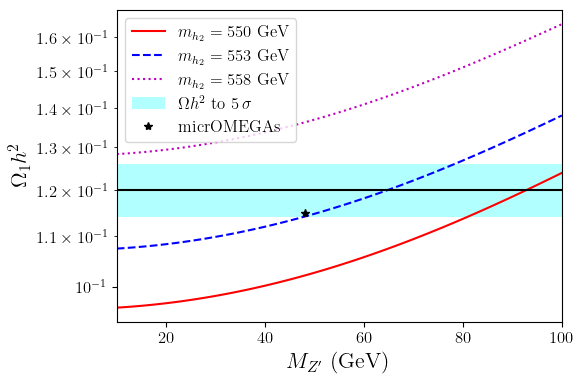

In [44]:
plt.figure(figsize=(6,4))

plt.semilogy( BP1.MZp, BP1.RD, 'r-',label=r'$m_{h_2}=550$ GeV')
#plt.semilogy( BP2.MZp, BP2.RD, 'm-',label='BP2 ' )
#plt.semilogy( BP3.MZp, BP3.RD, 'm-',label='BP3 ' )
plt.semilogy( BP4.MZp, BP4.RD, 'b--',label=r'$m_{h_2}=553$ GeV' )
plt.semilogy( BP5.MZp, BP5.RD, 'm:',label=r'$m_{h_2}=558$ GeV' )

nn=np.linspace(1e1,1.0e2,10)
plt.fill_between(nn,Omega_min,Omega_max,facecolor='cyan',alpha=0.3,label=r'$\Omega h^2$ to $5\,\sigma$')

plt.hlines(Omega,0.1,1e2, 'k',label='')

#plt.plot(xd.MZp, rd.RD_Fey/1,'ko',label=r'Feyncal:$\Omega h^2(\chi\chi\to Z^{\prime}Z^{\prime})$ with p-wave')

plt.plot(kk.MZp, kk.Omega3,'k*',label='micrOMEGAs')

#plt.plot(kk.MZp, kk.Omega3-0.001,'r.',label='')

plt.xlabel(r'$M_{Z^{\prime}}$ (GeV)',size=16)
plt.ylabel(r'$\Omega_1 h^2$',size=16)
plt.legend(loc='best',fontsize="12")

#plt.ylim(0.023,0.14)
plt.xlim(10, 100)
plt.tight_layout()

plt.savefig('plots/benchmark5.pdf')
#plt.show()

## $\langle \sigma vr\rangle$

In [40]:
v=0.12

#sv = a_coefficient(g1p, (MZp/m), m)+ b_coefficient(g1p, (MZp/m), m)*v**2
#print('sv(cm3/sec)=',sv,'sv(GeV-3)=',sv*(cmtoGeV**3/sectoGeV))

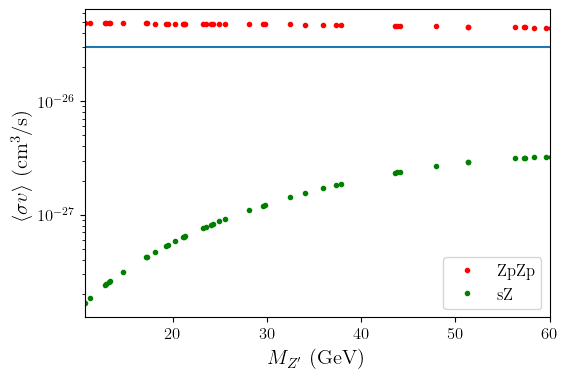

In [41]:
plt.figure(figsize=(6,4))

#(a+v**2*b)
plt.semilogy(xd.MZp, (rd.a_Fey+1*(3./25.)*rd.b_Fey)*tocm3sm1,'r.',label='ZpZp')

plt.semilogy(xd.MZp, (rd.a_sZ)*tocm3sm1,'g.',label='sZ')

plt.hlines(3e-26,10,90,)

plt.xlabel(r'$M_{Z^{\prime}}$ (GeV)',size=15)
plt.ylabel(r'$\langle \sigma v\rangle$ (cm$^3$/s)',size=15)
#plt.title('$M_1=86, M2=500,750, Yc=0.243, v=500, h_2=200$')
plt.legend()
#plt.grid()

#plt.ylim(0.11,0.2)
plt.xlim(xd.MZp.min(), 60)

#plt.savefig('plots/benchmark4.pdf')
plt.show()

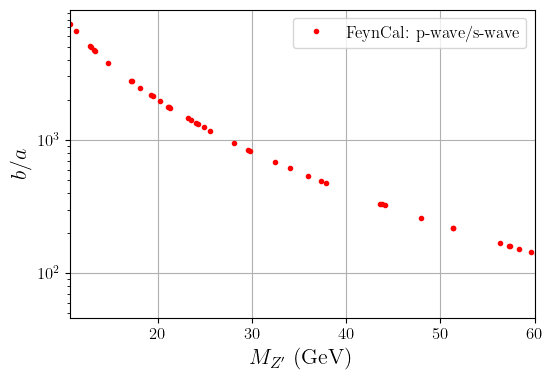

In [42]:
plt.figure(figsize=(6,4))

plt.semilogy(xd.MZp, (3./25.)*rd.b_Fey/rd.a_Fey,'r.',label='FeynCal: p-wave/s-wave')

plt.xlabel(r'$M_{Z^{\prime}}$ (GeV)',size=16)
plt.ylabel(r'$b/a$',size=16)
#plt.title('$M_1=86, M2=500,750, Yc=0.243, v=500, h_2=200$')
plt.legend()
plt.grid()

#plt.ylim(0.11,0.2)
plt.xlim(xd.MZp.min(), 60)

#plt.savefig('plots/benchmark4.pdf')
plt.show()

thermal cross-section $\sigma v$ check for a bechmark point for 1DM model

In [46]:
so = subprocess.getoutput('cat SPheno.spc.MDEOlight')

In [47]:
so.splitlines()

['# SUSY Les Houches Accord 2 - MDEOlight Spectrum + Decays + Flavour Observables',
 '# SPheno module generated by SARAH',
 '# ----------------------------------------------------------------------',
 '# SPheno v4.0.5  ',
 '#   W. Porod, Comput. Phys. Commun. 153 (2003) 275-315, hep-ph/0301101',
 '#   W. Porod, F.Staub, Comput.Phys.Commun.183 (2012) 2458-2469, arXiv:1104.1573',
 '# SARAH: 4.14.5  ',
 '#   F. Staub; arXiv:0806.0538 (online manual)',
 '#   F. Staub; Comput. Phys. Commun. 181 (2010) 1077-1086; arXiv:0909.2863',
 '#   F. Staub; Comput. Phys. Commun. 182 (2011)  808-833; arXiv:1002.0840',
 '#   F. Staub; Comput. Phys. Commun. 184 (2013)  1792-1809; arXiv:1207.0906',
 '#   F. Staub; Comput. Phys. Commun. 185 (2014)  1773-1790; arXiv:1309.7223 ',
 '# Including the calculation of flavor observables based on FlavorKit ',
 '#   W. Porod, F. Staub, A. Vicente; Eur.Phys.J. C74 (2014) 8, 2992; arXiv:1405.1434 ',
 '# Two-loop mass corrections to Higgs fields based on ',
 '#   M. D. 

In [48]:
MZp = eval(so.split('# VWm')[1].split()[1])
m = np.abs(eval(so.split('# Fv_3')[1].split()[1]))
print(MZp,m)

23.776911 86.0195399


In [49]:
subprocess.getoutput('cp SPheno.spc.MDEOlight SPheno.spc.MDEO1DM')
mo = subprocess.getoutput('~/Work/micromegas_5.0.6/MDEO1DM/./CalcOmega SPheno.spc.MDEO1DM')

mo.splitlines()

['',
 'Masses of odd sector Particles:',
 '~chi     : Mchi    =  86.020 || ',
 'Xf=2.60e+01 Omega h^2=1.20e-01',
 '',
 'vsigmaeff = 1.007e-25',
 '',
 '# Channels which contribute to 1/(omega) more than 1%.',
 '# Relative contributions in % are displayed',
 '  100% ~chi ~Chi ->Zp Zp ']

In [50]:
svmicro= eval(mo.split('vsigmaeff =')[1].split()[0])
print(svmicro)

1.007e-25


In [51]:
#subprocess.getoutput('~/Work/micromegas_6.0.3/MDEOlight/./CalcOmega SPheno.spc.MDEO')

'\nMasses of odd sector Particles:\n~chi     : Mchi    =  86.020 || ~~Xi1    : MXi1    = 500.000 || ~~Xi2    : MXi2    = 750.000 \n~~ETM    : METM    = 10000.000 || ~~ETI    : METI    = 10000.000 || ~~NS1    : MNS1    = 10000.000 \n~~NS2    : MNS2    = 100000.000 || \nOmega_1h^2=1.21E-01\nOmega_2h^2=2.04E-19\n'

In [53]:
print('a=',a_coefficient(g1p, (MZp/m), m),'b=',b_coefficient(g1p, (MZp/m), m))

a= 2.1415008773563774e-08 b= -2.0733068079708e-10


In [54]:
v=0.12
cmtoGeV=1.98E-14
sectoGeV=6.58E-25

sv = a_coefficient(g1p, (MZp/m), m)+ b_coefficient(g1p, (MZp/m), m)*v**2
print('sv(cm3/sec)=',sv,'sv(GeV-3)=',sv*(cmtoGeV**3/sectoGeV))

sv(cm3/sec)= 2.1412023211760296e-08 sv(GeV-3)= 2.5259653143280006e-25


In [55]:
sv*(cmtoGeV**3/sectoGeV)/svmicro

2.508406469044688